# PDP = Partial Dependence Plot

https://github.com/SauceCat/Medium-posts/blob/master/Machine%20Learning/Introducing%20PDPbox.md

## Friedman's PDP

### Example
아래와 같은 데이터셋에 대해 **feature A**가 Y에 얼마나 영향을 주는지 알고 싶은 경우(A는 A1, A2, A3만 가진다고 가정)
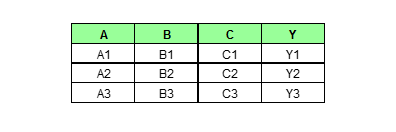


아래처럼 모든 경우의 데이터를 생성하고 값(Y)을 예측한다.
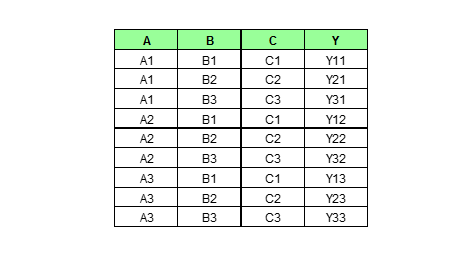

**nrows * num_grid_points** 개의 예측값이 생성되고 각 A값마다 평균을 낸다.
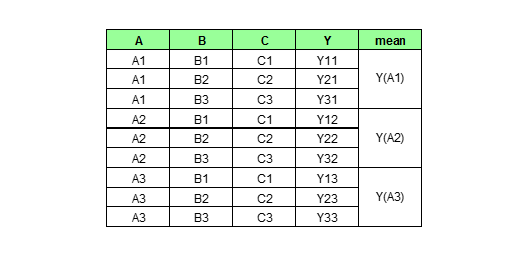

그렇게 계산된 평균을 plot한다.
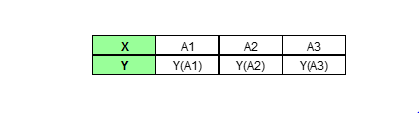


### 수식
$\hat{f_S}(x_S)={{1} \over {N}} \sum_{i=1}^{N}\hat{f}(x_S,x_{C}^{(i)})$,  
Plot $\hat {f_S}(x_S) \quad  \forall x_S \in [min(x_S), max(x_S)]$

## 장점
- 직관적이다.
- 해석이 쉽다. (feature가 변함에 따라 예측값이 어떻게 변하는지 확인할 수 있다.)


## 단점
- 각 변수가 독립이라는 가정하에 수행하는 것이기 때문에 현실에서 틀릴 수 있다.
- feature의 분포를 고려하지 않는다.
- **Heterogeneous effects**를 보일 수 있다. 아래 예시 참고

In [14]:
import numpy as np
from numpy.random import rand

n_samples = 20000

# Create array holding predictive feature
X1 = 4 * rand(n_samples) - 2
X2 = 4 * rand(n_samples) - 2
# Create y
y = X1 * X2

y = X1 * X2

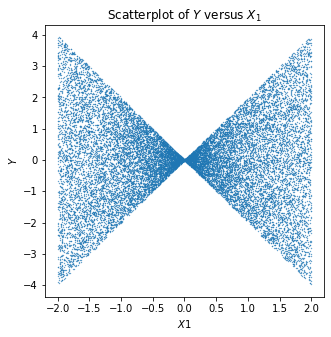

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(X1, y, s=0.1)
plt.xlabel('$X1$')
plt.ylabel('$Y$')
plt.title('Scatterplot of $Y$ versus $X_1$')
plt.show()

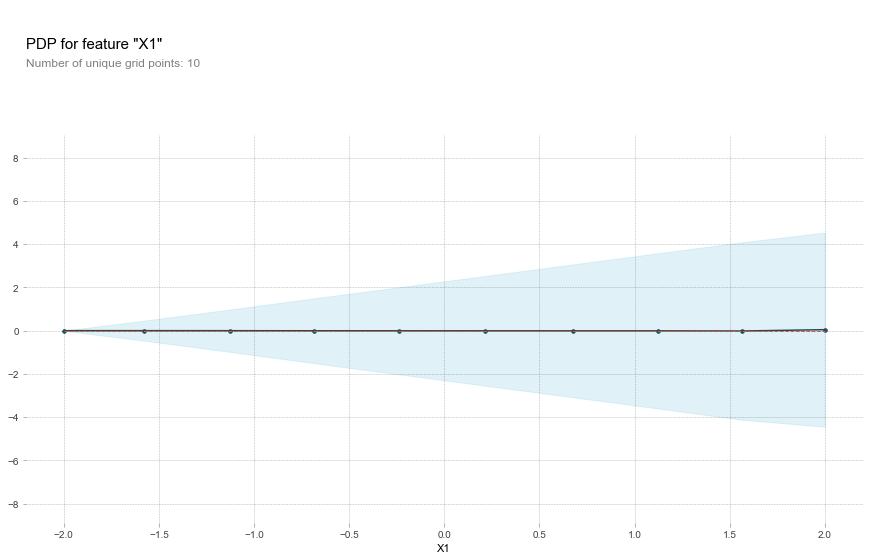

In [16]:
from pdpbox import pdp, get_dataset, info_plots
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

my_df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})
predictors_df = my_df.drop(['y'], axis=1)

my_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(predictors_df, my_df.y)


pdp_dist = pdp.pdp_isolate(model=my_model, dataset=my_df, model_features=['X1', 'X2'], feature='X1')
pdp.pdp_plot(pdp_dist, 'X1')
plt.show()

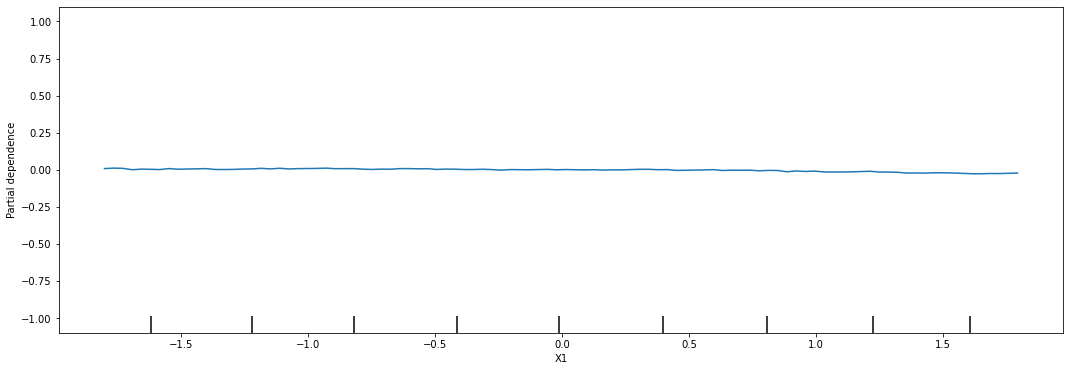

In [17]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

PartialDependenceDisplay.from_estimator(my_model, X=my_df, features=['X1'], ax=ax)
plt.ylim((-1.1, 1.1))
plt.show()

# 예제

In [5]:
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
names = [
    'age', 'workclass', 'fnlwgt', 'education',
    'education-num', 'marital-status', 'occupation',
    'relationship', 'race', 'gender', 'capital-gain',
    'capital-loss', 'hours-per-week', 'native-country',
    'salary'
]
dtypes = {
    'workclass': 'category',
    'education': 'category',
    'marital-status': 'category',
    'occupation': 'category',
    'relationship': 'category',
    'race': 'category',
    'gender': 'category',
    'native-country': 'category'
}

X = pd.read_csv(url, names=names, header=None, dtype=dtypes)
X['gender'] = X['gender'].str.strip().astype('category')  # Remove leading whitespace

In [6]:
from sklearn.preprocessing import OrdinalEncoder

# categorical = list(dtypes.keys())
categorical = [col for col in X.columns if X.dtypes[col] == 'category']

oe = OrdinalEncoder()
X_oe = pd.DataFrame(oe.fit_transform(X[categorical]), columns=categorical)
X[categorical] = X_oe

y = X.pop('salary').map({' <=50K': False, ' >50K': True})

X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,39,7.0,77516,9.0,13,4.0,1.0,1.0,4.0,1.0,2174,0,40,39.0
1,50,6.0,83311,9.0,13,2.0,4.0,0.0,4.0,1.0,0,0,13,39.0
2,38,4.0,215646,11.0,9,0.0,6.0,1.0,4.0,1.0,0,0,40,39.0
3,53,4.0,234721,1.0,7,2.0,6.0,0.0,2.0,1.0,0,0,40,39.0
4,28,4.0,338409,9.0,13,2.0,10.0,5.0,2.0,0.0,0,0,40,5.0


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

### 학습

In [8]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

pred = xgb.predict(X_test)

[11:23:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [9]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, pred)
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8649


## PDPBOX

https://www.kaggle.com/code/dansbecker/partial-plots

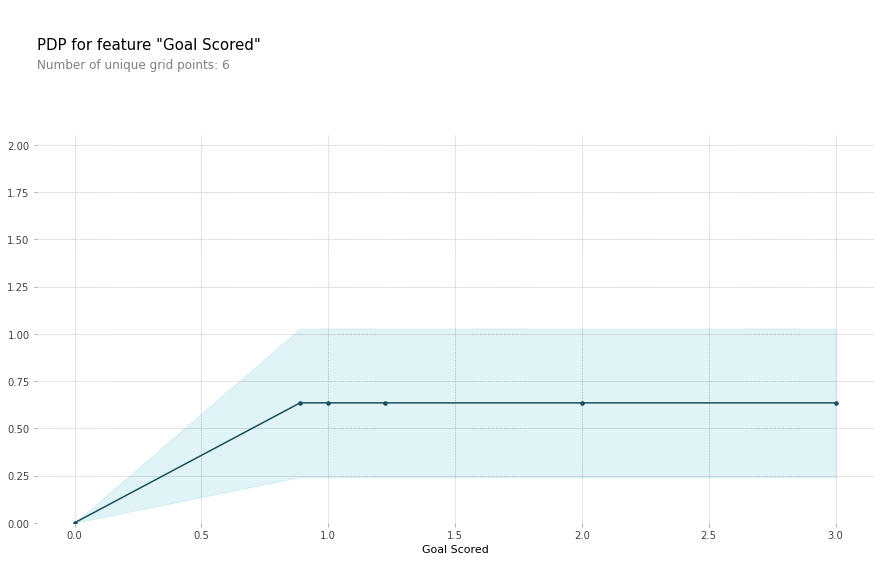

A few items are worth pointing out as you interpret this plot

- The y axis is interpreted as **change in the prediction** from what it would be predicted at the baseline or leftmost value.
- A blue shaded area indicates level of confidence

### `pdp_isolate()`
한글 출력
```python
plot_params = {'font_family':'NanumGothic', 'figsize':(14,20) , 'title_fontsize':17, 'subtitle_fontsize':13}
pdp_y = pdp.pdp_isolate(model=model, dataset=X_test, model_features=feature_names, feature=feature)
pdp.pdp_plot(pdp_y, feature, plot_params=plot_params)
```

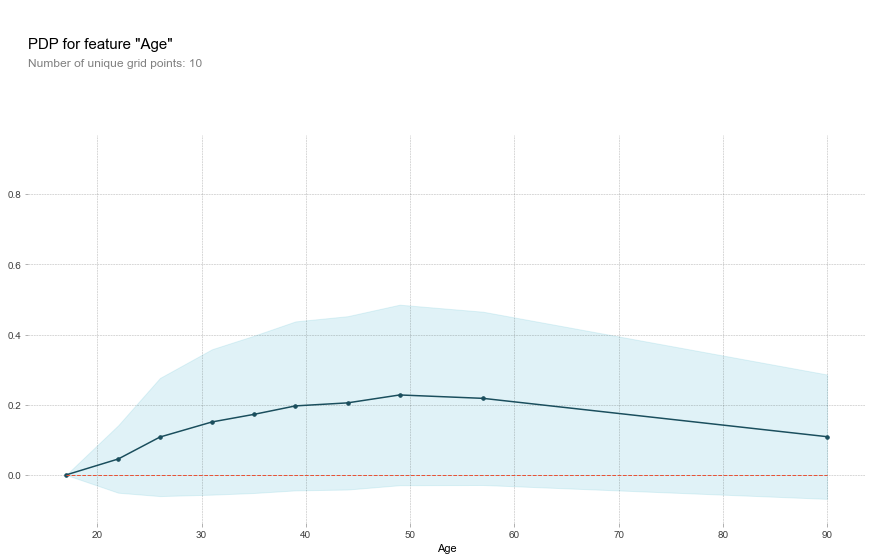

In [10]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_age = pdp.pdp_isolate(model=xgb, dataset=X_test, model_features=X.columns, feature='age')

# plot it
pdp.pdp_plot(pdp_age, 'Age')
plt.show()

### `pdp.pdp_plot()`
- `center=True`: 가장 좌측값을 기준으로 pdp의 차이를 plot. `False`일 땐 예측 절댓값을 보여줌
- https://github.com/SauceCat/PDPbox/issues/21
- Because the value of y-axis is not the absolute value of the prediction if you are using the default setting, with center=True. Instead, it represents the difference between the prediction values.

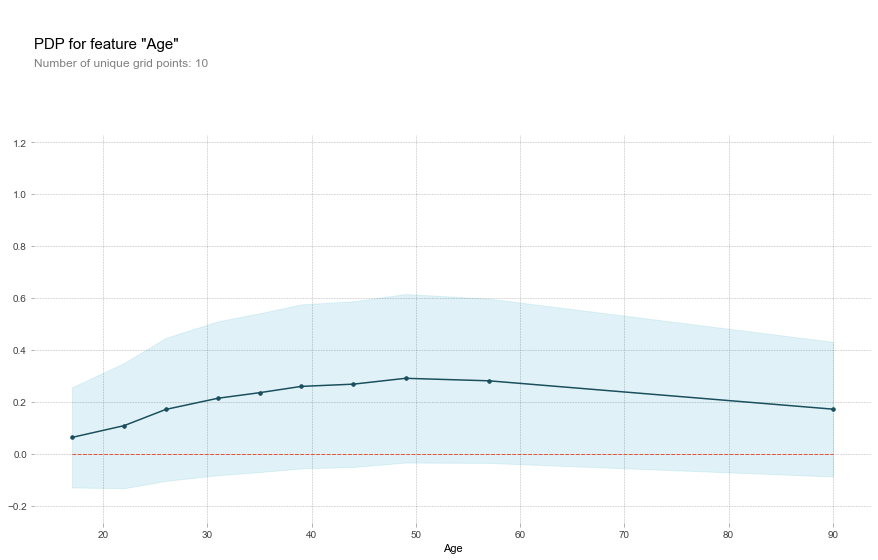

In [11]:
pdp.pdp_plot(pdp_age, 'Age', center=False)
plt.show()

### `pdp_interact()`
- 변수간 교호 작용 확인

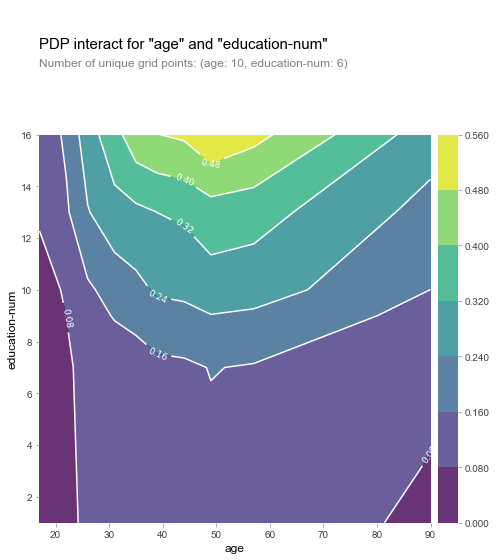

In [12]:
features_to_plot = ['age', 'education-num']
inter  =  pdp.pdp_interact(model=xgb, dataset=X_test, model_features=X.columns, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter, feature_names=features_to_plot, plot_type='contour')
plt.show()

## Scikit-learn

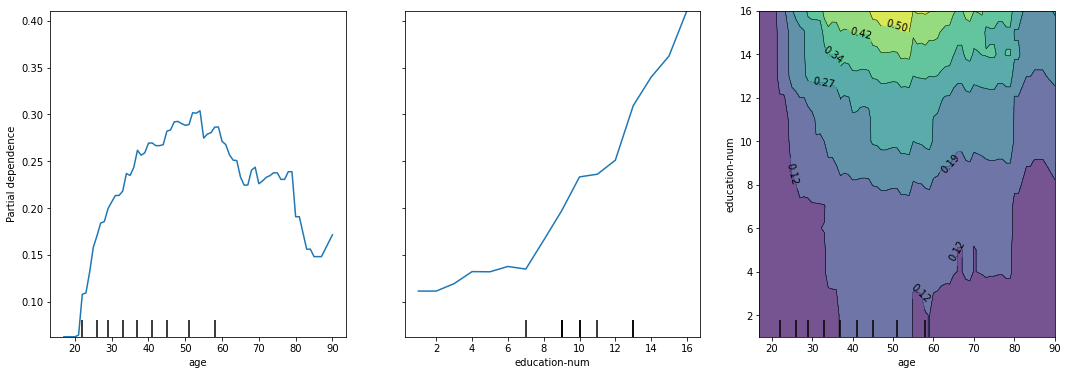

In [13]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
PartialDependenceDisplay.from_estimator(xgb, X=X_test, features=['age', 'education-num', ('age', 'education-num')], ax=ax)
plt.show()

## Analysis of the plots

https://scikit-learn.org/0.22/auto_examples/inspection/plot_partial_dependence.html

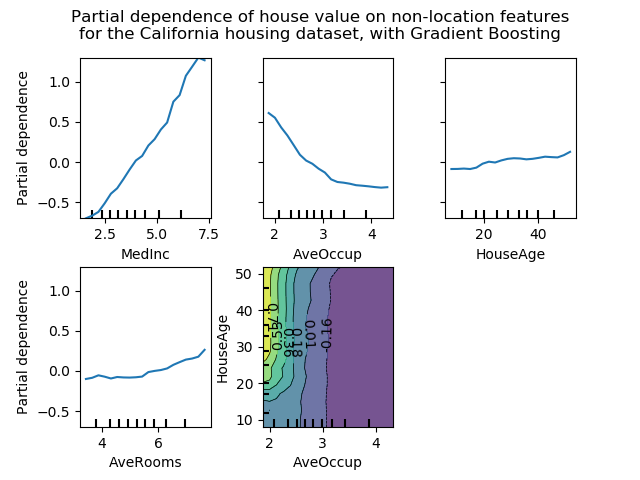

We can clearly see that the median house price shows a linear relationship with the median income (top left) and that the house price drops when the average occupants per household increases (top middle). The top right plot shows that the house age in a district does not have a strong influence on the (median) house price; so does the average rooms per household. The tick marks on the x-axis represent the deciles of the feature values in the training data.